  ## **Model-based Learning**

 *Generalization* is the what we strive to achieve when building machine learning solutions. Models are trained on past data to
 make predictions with future data. There are two ways models "learn": instance-based or model-based. Model-based learning covers
 the majority of machine learning solutions used in the real world.

 In the example below, suppose we want to know if money makes people happy. Data is gathered from two data sources:
 * [The OECD's Better Life Index](https://stats.oecd.org/index.aspx?DataSetCode=BLI)
 * [The IMF's GDP Per Country](https://www.imf.org/external/pubs/ft/weo/2016/01/weodata/weorept.aspx?pr.x=32&pr.y=8&sy=2015&ey=2015&scsm=1&ssd=1&sort=country&ds=.&br=1&c=512%2C668%2C914%2C672%2C612%2C946%2C614%2C137%2C311%2C962%2C213%2C674%2C911%2C676%2C193%2C548%2C122%2C556%2C912%2C678%2C313%2C181%2C419%2C867%2C513%2C682%2C316%2C684%2C913%2C273%2C124%2C868%2C339%2C921%2C638%2C948%2C514%2C943%2C218%2C686%2C963%2C688%2C616%2C518%2C223%2C728%2C516%2C558%2C918%2C138%2C748%2C196%2C618%2C278%2C624%2C692%2C522%2C694%2C622%2C142%2C156%2C449%2C626%2C564%2C628%2C565%2C228%2C283%2C924%2C853%2C233%2C288%2C632%2C293%2C636%2C566%2C634%2C964%2C238%2C182%2C662%2C453%2C960%2C968%2C423%2C922%2C935%2C714%2C128%2C862%2C611%2C135%2C321%2C716%2C243%2C456%2C248%2C722%2C469%2C942%2C253%2C718%2C642%2C724%2C643%2C576%2C939%2C936%2C644%2C961%2C819%2C813%2C172%2C199%2C132%2C733%2C646%2C184%2C648%2C524%2C915%2C361%2C134%2C362%2C652%2C364%2C174%2C732%2C328%2C366%2C258%2C734%2C656%2C144%2C654%2C146%2C336%2C463%2C263%2C528%2C268%2C923%2C532%2C738%2C944%2C578%2C176%2C537%2C534%2C742%2C536%2C866%2C429%2C369%2C433%2C744%2C178%2C186%2C436%2C925%2C136%2C869%2C343%2C746%2C158%2C926%2C439%2C466%2C916%2C112%2C664%2C111%2C826%2C298%2C542%2C927%2C967%2C846%2C443%2C299%2C917%2C582%2C544%2C474%2C941%2C754%2C446%2C698%2C666&s=NGDPDPC&grp=0&a=)


 Let's start with some code to load and prepare our data for some initial inspection. Visualization is a great method for finding
 insights in data prior to modeling.

In [0]:
# The function below merges the OECD's Life Satisfaction data and the IMF's GDP Per Capita data.
def prepare_country_stats(oecd_bli, gdp_per_capita):
    oecd_bli = oecd_bli[oecd_bli["INEQUALITY"]=="TOT"]
    oecd_bli = oecd_bli.pivot(index="Country", 
                              columns="Indicator", 
                              values="Value")
    
    gdp_per_capita.rename(columns={"2015": "GDP per capita"}, inplace=True)
    gdp_per_capita.set_index("Country", inplace=True)
    full_country_stats = pd.merge(left=oecd_bli, 
                                  right=gdp_per_capita,
                                  left_index=True, 
                                  right_index=True)
    
    full_country_stats.sort_values(by="GDP per capita", inplace=True)
    remove_indices = [0, 1, 6, 8, 33, 34, 35]
    keep_indices = list(set(range(36)) - set(remove_indices))
    return full_country_stats[["GDP per capita", 'Life satisfaction']].iloc[keep_indices]

The code cell below reads in the data, prepares it with the function just created, and visualizes it using a scatterplot. Does there appear to be a relationship between Life Satisfaction and GDP? Further, would you say that relationship appears *linear* in nature?

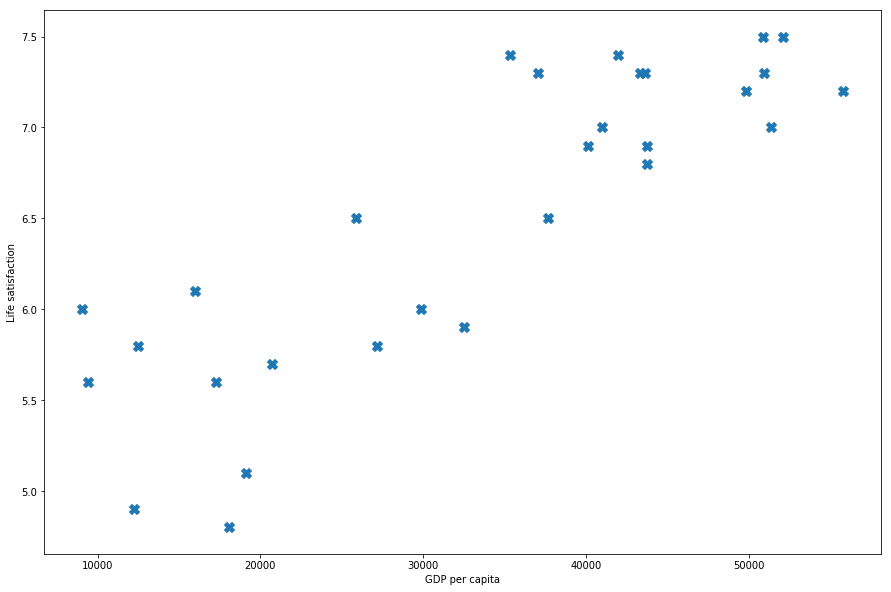

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# URLs for data on GitHub
imf_url = 'https://github.com/jsukup/handson-ml2/raw/master/datasets/lifesat/gdp_per_capita.csv'
oecd_url = 'https://github.com/jsukup/handson-ml2/raw/master/datasets/lifesat/oecd_bli_2015.csv'

# Load the data
oecd_bli = pd.read_csv(oecd_url, thousands=',')
gdp_per_capita = pd.read_csv(imf_url, 
                             thousands=',',
                             delimiter='\t',
                             encoding='latin1', 
                             na_values="n/a")

# Prepare the data
country_stats = prepare_country_stats(oecd_bli, gdp_per_capita)
X = np.c_[country_stats["GDP per capita"]]
y = np.c_[country_stats["Life satisfaction"]]

# Visualize the data
country_stats.plot(kind='scatter', 
                   x="GDP per capita", 
                   y='Life satisfaction',
                   figsize=(15,10),
                   marker='X',
                   s=100)

plt.show()      

One of the simplest models we can fit to this data is a *linear regression* model. If you remember the equation for a line
from elementary mathematics class, $y=mx+b$ you already know most of what's to know about linear regression. In machine learning,
the equation is usually written something like below. You can think of $\theta_0$ as analogous to $b$ (y-intercept) and $\theta_1$ as
analogous to $m$ (slope). Both $y$ and $x$ can also be substituted for Life Satisfaction and GDP, respectively:

\
 $$\LARGE
 Life Satisfaction=\theta_0 + \theta_1(GDP)
 $$

\

Machine learning algorithms are tasked with finding the best values for the two $\theta$ parameters. There is only *one* regression line
that best fits the data. Determining the equation for that line is the job of the **cost function** which measures how *poorly* the model
fits with each iteration of the algorithm, updates the two $\theta$ parameters to try and improve the model, measures the cost function
again, and iterates until the best parameters are found. In linear regression, the cost function typically measures the difference between
the model's predictions and actual values and tries to minimize this difference.

Python's **Scikit-Learn** package makes simple linear regression very easy to implement in a few lines of code.

In [19]:
from sklearn.linear_model import LinearRegression

# Select a linear model
model = LinearRegression()

# Train the model
model.fit(X, y)

# Make a prediction for Cyprus Life Satisfaction
X_new = [[22587]]  # Cyprus' GDP per capita
print(model.predict(X_new))

[[5.96242338]]


Now, plot the best fit regression line, the slope and y-intercept determined by the machine learning algorithm, and
the prediction for Cyprus. Note that the default cost function used by the algorithm is **mean squared error** which will be covered in the next lab.

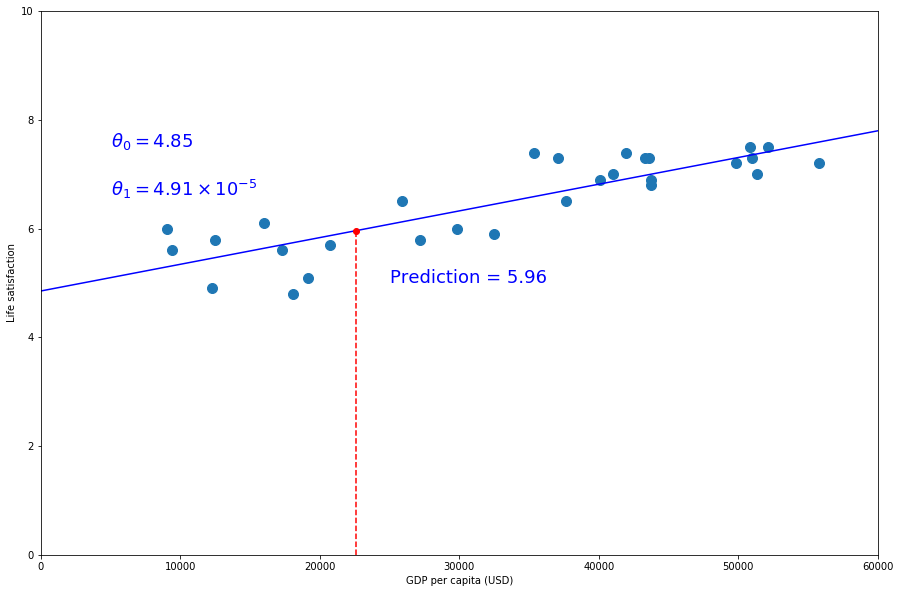

In [23]:
# Extract slope and y-intercept from model
t0, t1 = model.intercept_[0], model.coef_[0][0]

# Extract Cyprus GDP
cyprus_gdp_per_capita = gdp_per_capita.loc["Cyprus"]["GDP per capita"]

# Predict Life Satisfaction using model
cyprus_predicted_life_satisfaction = model.predict([[cyprus_gdp_per_capita]])[0][0]

# Plot regression model
country_stats.plot(kind='scatter', 
                   x="GDP per capita", 
                   y='Life satisfaction', 
                   figsize=(15,10), 
                   s=100)

plt.xlabel("GDP per capita (USD)")
X = np.linspace(0, 60000, 1000)
plt.plot(X, t0 + t1*X, "b") # Regression line
plt.axis([0, 60000, 0, 10])
plt.text(5000, 7.5, r"$\theta_0 = 4.85$", fontsize=18, color="b")
plt.text(5000, 6.6, r"$\theta_1 = 4.91 \times 10^{-5}$", fontsize=18, color="b")
plt.plot([cyprus_gdp_per_capita, cyprus_gdp_per_capita], [0, cyprus_predicted_life_satisfaction], "r--")
plt.text(25000, 5.0, r"Prediction = 5.96", fontsize=18, color="b")
plt.plot(cyprus_gdp_per_capita, cyprus_predicted_life_satisfaction, "ro")

plt.show()

Not only can linear regression be used for *prediction*, it can also be used for *inference*. For example, based on the slope value returned by the algorithm, we can infer that for every 1 USD increase in GDP, a country's Life Satisfaction increases, on average, by a factor of $4.91*10^-5$.

Using an instance-based learning model like **[k-nearest neighbors](https://scikit-learn.org/stable/modules/neighbors.html#classification)**
would elicit similar results. Slovenia, having the closest GDP to Cyprus, means a prediction of **"5.7"** would have been made. Or, averageing
the GDPs of the *3* closest countries in terms of GDP (Slovenia, Portugal,and Spain) would have predicted a Life Satisfaction of **"5.77"**. Also
fairly close to the prediction from the linear regression model. Switching between models in Scikit-Learn is as simple as changing two lines of code:

```
from sklearn.linear_model import LinearRegression
model = LinearRegression()
```

Instead to:

```
from sklearn.neighbors import KNeighborsRegressor
model = KNeighborsRegressor(n_neighbors=[ENTER A NUMBER OF SIMILAR COUNTRIES BY GDP TO EXAMINE])
```